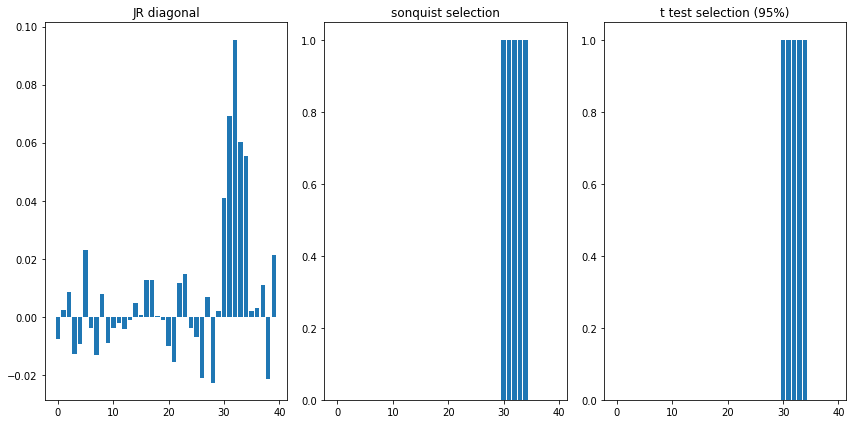

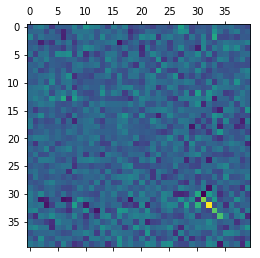

In [188]:
%matplotlib inline
from sklearn.linear_model import RidgeCV
import numpy as np

def regression(x, y):
    return RidgeCV().fit(x, y)

def unbagged_jr(x, y):
    c=regression(x, regression(y, x).predict(y)).coef_
    return c

def bagged_jr(x,y):
    n=x.shape[0]
    p = n//2
    x1=x[0:p]
    x2=x[p:n]
    y1=y[0:p]
    y2=y[p:n]
    c=regression(x2, regression(y1, x1).predict(y2)).coef_
    return c

def sonquist_morgan(x):
    z=np.sort(x)
    n=z.size
    m1=0
    m2=np.sum(z)
    mx=0
    best=-1
    for i in range(n-1): 
        m1+=z[i]
        m2-=z[i]
        ind=(i+1)*(n-i-1)*(m1/(i+1)-m2/(n-i-1))**2
        if ind>mx :
            mx=ind
            best=z[i]
    res=[0 for i in range(n)]
    for i in range(n): 
        if x[i]>best: res[i] = 1 
    return res
    

# Adapted from
# https://regressors.readthedocs.io/en/latest/
# https://github.com/nsh87/regressors/blob/master/regressors/stats.py
    
import scipy
from sklearn import metrics

def sse(clf, X, y, i):
    y_hat = clf.predict(X)
    sse = np.sum((y_hat[:, i] - y[:, i]) ** 2)
    return sse

def coef_se(clf, X, y, i):
    n = X.shape[0]
    X1 = np.hstack((np.ones((n, 1)), np.matrix(X)))
    se_matrix = scipy.linalg.sqrtm(
        metrics.mean_squared_error(y[:, i], clf.predict(X)[:, i]) *
        np.linalg.inv(X1.T * X1+1.0e-7*np.identity(X1.shape[1]))  #FC: minimal regularization
    )
    return np.diagonal(se_matrix)

def coef_tval(clf, X, y, i):
    b = np.array(clf.coef_[i] / coef_se(clf, X, y, i)[1:])
    
    if clf.fit_intercept:
        a = np.array(clf.intercept_[i] / coef_se(clf, X, y, i)[0])
        return np.append(a, b)
    return b

def coef_pval(clf, X, y, i):
    n = X.shape[0]
    t = coef_tval(clf, X, y, i)
    t[t<0]=0 #FC no negative coeffs, should the confidence interval be changed?
    p = 2 * (1 - scipy.stats.t.cdf(abs(t), n - 1))
    return p

    
    
#  Y = F(EX+N)
def make_data(n=1000, d_x=40, d_z=30, d_y=100, snr=0.05, nc=2):   
    X = np.random.randn(n, d_x) 
    nc = d_x if nc <= 0 else nc
    E = np.zeros((d_x, d_z))        
    E[-nc-5:-5, :] = np.random.randn(nc, d_z)
    Z = X @ E *snr + np.random.randn(n, d_z)
    F = np.random.randn(d_z, d_y)  
    Y = Z @ F 
    return Y, X, E, F



y, x, e, f = make_data(nc=5)

mat_jr = bagged_jr(x, y)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("JR diagonal")
plt.bar(range(mat_jr.shape[0]), np.diag(mat_jr))

plt.subplot(1, 3, 2)
plt.title("sonquist selection")
z2=sonquist_morgan(np.diag(mat_jr))
plt.bar(range(len(z2)), z2)

n=x.shape[0]
p = n//2
x1=x[0:p]
x2=x[p:n]
y1=y[0:p]
y2=y[p:n]
xhat=regression(y1, x1).predict(y2)
ridge = RidgeCV(fit_intercept=False).fit(x2, xhat)
p_values = np.array([coef_pval(ridge, x2, xhat, i) for i in range(xhat.shape[1])])

z=np.diag(p_values)
plt.subplot(1, 3, 3)
plt.title("t test selection (95%)")
plt.bar(range(z.shape[0]), (z<0.05))

plt.tight_layout()

plt.matshow(mat_jr)


    